In [1]:
import pandas as pd
import graphviz
from sklearn import tree
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
%matplotlib inline

In [2]:
titanic_data=pd.read_csv('train.csv')
titanic_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


1. Препроцессинг данных (.info, .description, есть ли пропущенные значения, что с этими значениями сделать, есть ли аномалии в данных и тд)

In [3]:
titanic_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

2. Отбираем фичи (survived - таргет, а не фича, поэтому ее тоже убираем)

In [4]:
X=titanic_data.drop(['PassengerId', 'Survived','Name', 'Ticket', 'Cabin'], axis=1)
y=titanic_data.Survived # таргет

In [5]:
X=pd.get_dummies(X) # автоматически делает one-hot кодирование, разбивая строковый Sex на две колонки Sex_female и Sex_male
X=X.drop(['Sex_male'], axis=1) # Нам нужна только одна колонка, поэтому вторую удаляем
X.rename(columns = {'Sex_female':'Sex'}, inplace = True) # Переименовываем оставшуюся колонку

In [6]:
# Заполнение пропущенных значений Age медианным значением возраста  в зависимости от пола
Sex = X['Sex'].unique().tolist() #список уникальных значений пола
age = []
for i in Sex: #расчет медианы возраста для разных значений пола
    a = X.loc[X['Sex'] == i]['Age'].median()
    age.append(a)
age_dict = dict(zip(Sex, age)) #словарь, где каждому значению пола соответствует медиана возраста
X['Age'] = X['Age'].fillna(X['Sex'].map(age_dict)) #собственно fillna

3. Создаем дерево решений

In [7]:
clf=tree.DecisionTreeClassifier(criterion = 'entropy') 
# он может работать только с числовыми данными и чтобы без nan

In [8]:
clf.fit(X,y)
clf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

4. Отрисовываем дерево решений

In [ ]:
plt.figure(figsize=(100, 50))
tree.plot_tree(clf, 
               feature_names=list(X), 
               class_names=['Died', 'Survived'], 
               filled=True,
               rounded=True,
               fontsize = 11)
plt.show()
# Модель переобучилась, тк дерево решений из коробки не ставит себе цель найти закономерность, а разбивает на классы просто
# Решение - ограничить глубину дерева

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42)

5. Валидация модели

In [20]:
# clf.score(X,y) 
# процент правильных ответов

0.9775533108866442

In [21]:
# clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy')

In [22]:
# clf.score(X_train, y_train)

0.9748322147651006

In [23]:
# clf.score(X_test, y_test)

0.7864406779661017

=> Точность на тренировочной выборке 0.9748322147651006, на тестовой 0.7864406779661017. Значит модель переобучена

Заново обучаем, но указываем ограничение дереву - его глубину

In [28]:
# clf=tree.DecisionTreeClassifier(criterion = 'entropy', max_depth=4)

In [29]:
# clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [30]:
# clf.score(X_train, y_train)

0.8338926174496645

In [31]:
# clf.score(X_test, y_test)

0.823728813559322

Валидируем модель. Делаем вручную, хотя есть специальная бибилиотека в sklearn

In [8]:
max_depth_values=range(1,100)

In [9]:
scores_data=pd.DataFrame()

In [ ]:
# for max_depth in max_depth_values:
#     clf=tree.DecisionTreeClassifier(criterion = 'entropy', max_depth=max_depth)
#     clf.fit(X_train, y_train)
#     train_score=clf.score(X_train, y_train)
#     test_score=clf.score(X_test, y_test)

#     temp_score_data=pd.DataFrame({'max_depth': [max_depth], 'train_score': [train_score], 'test_score': [test_score]})
    
#     scores_data=scores_data.append(temp_score_data)

In [ ]:
# scores_data.head()

In [48]:
# scores_data_long=pd.melt(scores_data, id_vars=['max_depth'], value_vars=['train_score','test_score'], 
# var_name='set_type',value_name='score')

In [ ]:
# scores_data_long.head()

In [ ]:
# sns.lineplot(x='max_depth', y='score', hue='set_type',data=scores_data_long)
# Из графика видно, что до глубины дерева 5 модель еще недообучена, а примерно после 5 уже происходит переобучение

Все еще наша модель переобучена, так как мы подкручивали параметры так, чтобы увеличить точность на тестовой выборке. Полностью избежать переобучения невозможно, но можно стараться минимизировать

Кросвалидация - обучаем на обучающей выборке, подкручиваем параметры на валидационной выборке - проверяем модель (как делали выше для обучающей и тестовой), показываем тестовую выборку модели

Разделяем на тренировочную и тестовую выборки. Тренировочную выборку разделяем еще на, например, 5 кусочков данных (параметр cv в cross_val_score). Далее, тренируем модель на 2,3,4,5 кусочках, а тестируем на 1, потом обучаем на 1,3,4,5 кусочках, тестируем на 2 и тд. На кажлом этапе считаем точность. После всех этапов считаем усредненную точность

In [10]:
# Заново создаем классификатор
clf=tree.DecisionTreeClassifier(criterion = 'entropy', max_depth=4)

In [11]:
cross_val_score(clf, X_train, y_train, cv=5).mean()
# получили среднюю точность на кросс-валидации

0.7903081232492998

Изменим нашу валидацию

In [ ]:
for max_depth in max_depth_values:
    clf=tree.DecisionTreeClassifier(criterion = 'entropy', max_depth=max_depth)
    clf.fit(X_train, y_train)
    train_score=clf.score(X_train, y_train)
    test_score=clf.score(X_test, y_test)

    mean_cross_val_score=cross_val_score(clf, X_train, y_train, cv=5).mean()

    temp_score_data=pd.DataFrame({'max_depth': [max_depth], 
    'train_score': [train_score], 
    'test_score': [test_score],
    'cross_val_score': [mean_cross_val_score]})
    
    scores_data=scores_data.append(temp_score_data)

In [13]:
scores_data.head()

,max_depth,train_score,test_score,cross_val_score
0,1,0.781879,0.796610,0.781961
0,2,0.805369,0.776271,0.770196
0,3,0.823826,0.820339,0.790322
0,4,0.833893,0.823729,0.790308
0,5,0.842282,0.810169,0.791989


In [14]:
scores_data_long=pd.melt(scores_data, id_vars=['max_depth'], value_vars=['train_score','test_score','cross_val_score'], 
var_name='set_type',value_name='score')

In [ ]:
scores_data_long.query('set_type=="cross_val_score"').head(20)

<AxesSubplot:xlabel='max_depth', ylabel='score'>

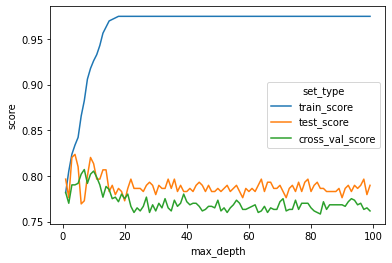

In [15]:
sns.lineplot(x='max_depth', y='score', hue='set_type',data=scores_data_long)

Создаем "лучший" классификатор и тестируем на тестовой выборке, которую он никогда не видел

In [17]:
best_clf=tree.DecisionTreeClassifier(criterion = 'entropy', max_depth=7)

In [18]:
cross_val_score(clf, X_test, y_test, cv=5).mean()

0.7966101694915254